In [1]:
import dpln
from dpln import nn, optim
from dpln.nn import functional as F
from dpln.util import load_pickle
from dpln.data import Dataset, DataLoader

import numpy as np
from matplotlib import pyplot as plt

print(dpln.__version__)

0.1.1


In [2]:
mnist = load_pickle("mnist.pkl")

In [3]:
class MnistDataset(Dataset):
    def __init__(self, images, labels, transform=None, transform_target=None):
        if len(images) != len(labels):
            raise ValueError("length of images and labels must equal")
        self.images = images
        self.labels = labels
        self.transform = transform
        self.transform_target = transform_target

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        lab = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        if self.transform_target:
            lab = self.transform_target(lab)
        return img, lab


In [4]:
def transform(img):
    return img.reshape(1, 28, 28) / 256


def transform_target(lab):
    return np.array([lab])


In [5]:
train_ds = MnistDataset(mnist["train_images"], mnist["train_labels"],
                        transform=transform, transform_target=transform_target)
test_ds = MnistDataset(mnist["test_images"], mnist["test_labels"],
                       transform=transform, transform_target=transform_target)


In [6]:
def batch_fn(batch):
    images = []
    labels = []
    for i in batch:
        images.append(i[0][np.newaxis, :])
        labels.append(i[1])
    b_img = dpln.Tensor(np.concatenate(images))
    b_lab = dpln.Tensor(np.concatenate(labels).squeeze())
    return b_img, b_lab


In [7]:
train_ld = DataLoader(train_ds, 64, batch_fn)
test_ld = DataLoader(test_ds, 1000, batch_fn)

In [8]:
sample_image_batch, sample_label_batch = next(iter(train_ld))
sample_image = sample_image_batch.numpy()[0].reshape(1, 784)
sample_label = sample_label_batch.numpy()[0].reshape(1, 1)

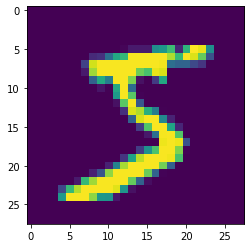

In [9]:
plt.imshow(sample_image.reshape(28, 28))

In [10]:
print(sample_label)

[[5]]


In [11]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(4608, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = F.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


model = Model()


In [12]:
print(model)

Model


In [13]:
optm = optim.SGD(model.parameters(), 1)

In [14]:
train_loss = []
train_accu = []

In [15]:
def train_step(epoch: int, model, train_ld, optm):
    batch_size = len(train_ld)
    for b, (inp, tar) in enumerate(train_ld):
        optm.zero_grad()
        pre = model(inp)
        loss = F.nll_loss(pre, tar)
        loss.backward()
        optm.step()
        loss_v = loss.item()
        train_loss.append(loss_v)
        print(f"Epoch:{epoch + 1}\tStep:{b}/{batch_size}\t\tLoss:{loss_v}")


In [16]:
def accuracy(model, test_ld) -> float:
    correct = 0
    total = 0
    for (inp, tar) in test_ld:
        pre = model(inp)
        pre_am = pre.detach().numpy().argmax(axis=-1)
        res = np.where(pre_am == tar.numpy(), 1, 0)
        correct += res.sum()
        total += res.size
    return correct / total


In [17]:
epochs = 20

In [18]:
for i in range(epochs):
    train_step(i, model, train_ld, optm)
    accu = accuracy(model, test_ld)
    train_accu.append(accu)
    print(f"Epoch:{i+1}\tAccu:{accu}")


Epoch:1	Step:0/937		Loss:2.3024964035250695
Epoch:1	Step:1/937		Loss:2.2731418695760137


KeyboardInterrupt: 

In [ ]:
plt.figure()
plt.title("train loss")
plt.plot(train_loss)
plt.show()

In [ ]:
plt.figure()
plt.title("train accuracy")
plt.plot(train_accu)
plt.show()